<h1 class='font-effect-3d' style='color:#31c831; font-family:Orbitron;'>Links, Helpful Functions, and Python Modules</h1>

---
- [Guide to the Sequential model](https://keras.io/getting-started/sequential-model-guide/)
- [Model evaluation: quantifying the quality of predictions](http://scikit-learn.org/stable/modules/model_evaluation.html)

[Extended Version](https://olgabelitskaya.github.io/MLE_ND_P6_V0.html) & [Colaboratory Version](https://colab.research.google.com/drive/13YVEPwrMQC2TO2GGPvV95Bysh4dhd8we)

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto&effect=3d');
body {background-color:honeydew;}
span {color:black; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:#31c831;} 
div.input_prompt {color:forestgreen;} 
div.output_area pre,div.output_subarea {font-size:15px; color:#31c831;}
div.output_stderr pre {background-color:honeydew;}
</style>

In [2]:
import warnings; warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore",category=DataConversionWarning)
import os,zipfile,numpy as np,pandas as pd,scipy as sc
import pylab as pl,seaborn as sn,sympy as sp,keras as ks
pl.style.use('seaborn-whitegrid')
fw='weights.sberbank.hdf5'
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,median_absolute_error,r2_score
from sklearn.metrics import mean_absolute_error,explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential,Model
from keras.layers import Conv1D,Conv2D,MaxPooling1D,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import Input,Dense,LSTM,Activation,Flatten,Dropout

Using TensorFlow backend.


In [3]:
def display_cat(df,feature):
    print ('\n'+'<_>'*20);
    print ('\n'+feature+': '+str(len(set(df[feature]))))
    sp.pprint(set(df[feature]))
def robust_scaler(Xtrain,ytrain,Xtest,ytest):
    scale_X=RobustScaler(); scale_y=RobustScaler()
    Xtrain=scale_X.fit_transform(Xtrain)
    Xtest=scale_X.transform(Xtest)
    ytrain=scale_y.fit_transform(ytrain.reshape(-1,1))
    ytest=scale_y.transform(ytest.reshape(-1,1))
    return Xtrain,ytrain,Xtest,ytest
def regression(regressor,X_train,X_test,y_train):
    regressor.fit(X_train,y_train)
    return regressor.predict(X_train),regressor.predict(X_test)
def scores(title,y_train,y_test,y_train_reg,y_test_reg):
    separator='-_-'*10; sp.pprint(title); print('<_>'*20)
    print("EV score. Train: "+\
          str(explained_variance_score(y_train,y_train_reg)))
    print("EV score. Test: "+\
          str(explained_variance_score(y_test,y_test_reg)))
    print(separator)
    print("R2 score. Train: "+\
          str(r2_score(y_train,y_train_reg)))
    print("R2 score. Test: "+\
          str(r2_score(y_test,y_test_reg)))
    print(separator)
    print("MSE score. Train: "+\
          str(mean_squared_error(y_train,y_train_reg)))
    print("MSE score. Test: "+\
          str(mean_squared_error(y_test,y_test_reg)))
    print(separator)
    print("MAE score. Train: "+\
          str(mean_absolute_error(y_train,y_train_reg)))
    print("MAE score. Test: "+\
          str(mean_absolute_error(y_test,y_test_reg)))
    print(separator)
    print("MdAE score. Train: "+\
          str(median_absolute_error(y_train,y_train_reg)))
    print("MdAE score. Test: "+\
          str(median_absolute_error(y_test,y_test_reg))) 
def display_importance(regressor,X,y,title,n):
    importances=regressor.fit(X,y).feature_importances_
    indices=np.argsort(importances)[::-int(1)][:int(n)]
    pl.figure(figsize=(11,4))
    pl.xlabel("Feature Index"); pl.ylabel("Feature Importance")
    pl.bar(range(n),importances[indices],
           color="forestgreen",align="center",alpha=.5)
    pl.xticks(range(n),indices); pl.title(title); pl.show()
def history_plot(fit_history):
    keys=list(fit_history.history.keys())[0:4]
    pl.figure(figsize=(11,9)); pl.subplot(211)
    pl.plot(fit_history.history[keys[0]],
            color='#31c831',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='forestgreen',label='test')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.title('Loss Function'); pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='#31c831',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='forestgreen',label='test')
    pl.xlabel("Epochs"); pl.ylabel("MAE"); pl.legend()
    pl.title('Mean Absolute Error'); pl.show() 

<h1 class='font-effect-3d' style='color:#31c831; font-family:Orbitron;'> Problem Statement </h1>
Sberbank is challenging programmers to develop algorithms which use a broad spectrum of features to predict real prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.
<h1 class='font-effect-3d' style='color:#31c831; font-family:Orbitron;'>Datasets and Inputs</h1>
<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'>Description by files</h4>

In [4]:
%%html
<div id="data"><iframe src="https://olgabelitskaya.github.io/data_dictionary.txt" height="200" width="90%"></iframe></div>

<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'> Data Loading and Displaying</h4>

In [5]:
for zf in ['macro.csv.zip','train.csv.zip','test.csv.zip']:
    input_file=open('../input/'+zf,'rb')
    output_file=open(zf,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    zipf=zipfile.ZipFile(zf,'r')
    zipf.extractall(''); zipf.close()
macro=pd.read_csv('macro.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
macro[100:103].T[:9],train[200:203].T[10:19]

(                             100         101         102
 timestamp             2010-04-11  2010-04-12  2010-04-13
 oil_urals                  82.87       82.87       82.87
 gdp_quart                 9995.8      9995.8      9995.8
 gdp_quart_growth             4.1         4.1         4.1
 cpi                        319.8       319.8       319.8
 ppi                        350.2       350.2       350.2
 gdp_deflator                 NaN         NaN         NaN
 balance_trade             16.604      16.604      16.604
 balance_trade_growth        14.1        14.1        14.1,
                              200             201         202
 state                        NaN             NaN         NaN
 product_type          Investment      Investment  Investment
 sub_area            Horoshevskoe  Juzhnoe Butovo     Marfino
 area_m               8.56843e+06     2.61551e+07  2.1044e+06
 raion_popul                56535          178264       26943
 green_zone_part        0.0636477        0.1378

<h1 class='font-effect-3d' style='color:#31c831; font-family:Orbitron;'> Solution Statement</h1>
<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'> Selection of features</h4>

In [6]:
X_list_num=['timestamp','full_sq','floor','max_floor','num_room','area_m',
            'kremlin_km','big_road2_km','big_road1_km','workplaces_km',
            'stadium_km','swim_pool_km','fitness_km','detention_facility_km',
            'cemetery_km','radiation_km','oil_chemistry_km',
            'theater_km','exhibition_km','museum_km','park_km',
            'public_healthcare_km','metro_min_walk','metro_km_avto', 
            'bus_terminal_avto_km','public_transport_station_min_walk',
            'railroad_station_walk_min','railroad_station_avto_km',
            'kindergarten_km','school_km','preschool_km','university_km',
            'additional_education_km','shopping_centers_km',
            'big_market_km','ekder_all','work_all','young_all']
X_list_cat=['sub_area','ID_metro','office_raion','sport_objects_raion',
            'raion_popul','healthcare_centers_raion',
            'school_education_centers_raion',
            'preschool_education_centers_raion']
features_train=train[X_list_num]
features_test=test[X_list_num]
target_train=train['price_doc']

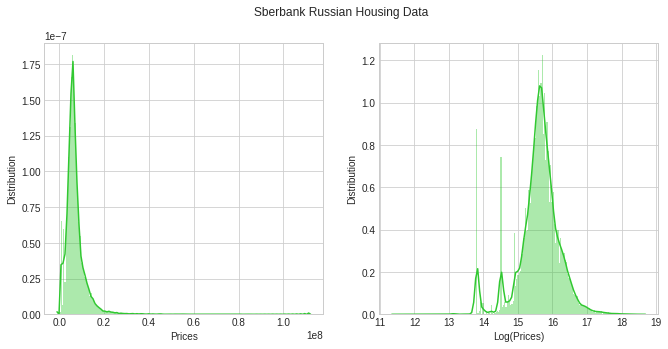

In [7]:
f,(ax1,ax2)=pl.subplots(ncols=2,figsize=(11,5))
sn.distplot(target_train,bins=200,color='#31c831',ax=ax1)
ax1.set_xlabel("Prices"); ax1.set_ylabel("Distribution")
sn.distplot(np.log(target_train),bins=200,color='#31c831',ax=ax2)
ax2.set_xlabel("Log(Prices)")
ax2.set_ylabel("Distribution")
pl.suptitle('Sberbank Russian Housing Data'); pl.show()

In [8]:
print("Sberbank Russian Housing Dataset Statistics: \n")
print("Number of houses = ",len(target_train))
print("Number of features = ",len(list(features_train.keys())))
print("Minimum house price = ",np.min(target_train))
print("Maximum house price = ",np.max(target_train))
print("Mean house price = ", "%.2f"%np.mean(target_train))
print("Median house price = ", "%.2f"%np.median(target_train))
print("Standard deviation of house prices =","%.2f"%np.std(target_train))

Sberbank Russian Housing Dataset Statistics: 

Number of houses =  30471
Number of features =  38
Minimum house price =  100000
Maximum house price =  111111112
Mean house price =  7123035.28
Median house price =  6274411.00
Standard deviation of house prices = 4780032.89


<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'> Fill in missing values</h4>

In [9]:
pd.DataFrame(train[X_list_num].isnull()\
.sum()[train[X_list_num].isnull().sum()!=0],columns=['nan'])

,nan
floor,167
max_floor,9572
num_room,9572
metro_min_walk,25
railroad_station_walk_min,25


In [10]:
pd.DataFrame(test[X_list_num].isnull()\
.sum()[test[X_list_num].isnull().sum()!=0],columns=['nan'])

,nan
metro_min_walk,34
railroad_station_walk_min,34


In [11]:
df_train=pd.DataFrame(train,columns=X_list_num)
df_train_cat=pd.DataFrame(train,columns=X_list_num+X_list_cat)
df_test=pd.DataFrame(test,columns=X_list_num)
df_test_cat=pd.DataFrame(test,columns=X_list_num+X_list_cat)
df_train['prices']=target_train
df_train_cat['prices']=target_train
df_train=df_train.dropna(subset=['num_room'])
df_train_cat=df_train_cat.dropna(subset=['num_room'])
for el in ['metro_min_walk','railroad_station_walk_min','floor']:
    for df in [df_train,df_train_cat,df_test,df_test_cat]:
        df[el]=df[el].interpolate(method='linear')
len(df_train),len(df_test)

(20899, 7662)

<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'> Categorical and Macro Features</h4>
One Macro Feature

In [12]:
usdrub_pairs=dict(zip(list(macro['timestamp']),list(macro['usdrub'])))
# salary_pairs=dict(zip(list(macro['timestamp']),list(macro['salary'])))
for df in [df_train,df_train_cat,df_test,df_test_cat]:
    df['timestamp'].replace(usdrub_pairs,inplace=True)
    df.rename(columns={'timestamp':'usdrub'},inplace=True)

Exploration: numbers of categories and values for categorical features

In [13]:
for feature in X_list_cat:
    display_cat(df_train_cat,feature)


<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>

sub_area: 146
{Ajeroport, Akademicheskoe, Alekseevskoe, Altuf'evskoe, Arbat, Babushkinskoe, 
Basmannoe, Begovoe, Beskudnikovskoe, Bibirevo, Birjulevo Vostochnoe, Birjulevo
 Zapadnoe, Bogorodskoe, Brateevo, Butyrskoe, Caricyno, Cheremushki, Chertanovo
 Central'noe, Chertanovo Juzhnoe, Chertanovo Severnoe, Danilovskoe, Dmitrovsko
e, Donskoe, Dorogomilovo, Filevskij Park, Fili Davydkovo, Gagarinskoe, Gol'jan
ovo, Golovinskoe, Hamovniki, Horoshevo-Mnevniki, Horoshevskoe, Hovrino, Ivanov
skoe, Izmajlovo, Jakimanka, Jaroslavskoe, Jasenevo, Juzhnoe Butovo, Juzhnoe Me
dvedkovo, Juzhnoe Tushino, Juzhnoportovoe, Kapotnja, Kon'kovo, Koptevo, Kosino
-Uhtomskoe, Kotlovka, Krasnosel'skoe, Krjukovo, Krylatskoe, Kuncevo, Kurkino, 
Kuz'minki, Lefortovo, Levoberezhnoe, Lianozovo, Ljublino, Lomonosovskoe, Losin
oostrovskoe, Mar'ina Roshha, Mar'ino, Marfino, Matushkino, Meshhanskoe, Metrog
orodok, Mitino, Molzhaninovskoe, Moskvorech'e-Saburovo

In [14]:
for feature in X_list_cat:
    display_cat(df_test_cat,feature)


<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>

sub_area: 145
{Ajeroport, Akademicheskoe, Alekseevskoe, Altuf'evskoe, Arbat, Babushkinskoe, 
Basmannoe, Begovoe, Beskudnikovskoe, Bibirevo, Birjulevo Vostochnoe, Birjulevo
 Zapadnoe, Bogorodskoe, Brateevo, Butyrskoe, Caricyno, Cheremushki, Chertanovo
 Central'noe, Chertanovo Juzhnoe, Chertanovo Severnoe, Danilovskoe, Dmitrovsko
e, Donskoe, Dorogomilovo, Filevskij Park, Fili Davydkovo, Gagarinskoe, Gol'jan
ovo, Golovinskoe, Hamovniki, Horoshevo-Mnevniki, Horoshevskoe, Hovrino, Ivanov
skoe, Izmajlovo, Jakimanka, Jaroslavskoe, Jasenevo, Juzhnoe Butovo, Juzhnoe Me
dvedkovo, Juzhnoe Tushino, Juzhnoportovoe, Kapotnja, Kon'kovo, Koptevo, Kosino
-Uhtomskoe, Kotlovka, Krasnosel'skoe, Krjukovo, Krylatskoe, Kuncevo, Kurkino, 
Kuz'minki, Lefortovo, Levoberezhnoe, Lianozovo, Ljublino, Lomonosovskoe, Losin
oostrovskoe, Mar'ina Roshha, Mar'ino, Marfino, Matushkino, Meshhanskoe, Metrog
orodok, Mitino, Molzhaninovskoe, Moskvorech'e-Saburovo

In [15]:
# the missing category in the testing set
for feature in X_list_cat:
    for element in list(set(df_test_cat[feature])):
        if element not in list(set(df_train_cat[feature])): 
            print (feature,element)

ID_metro 224


In [16]:
# replacing categorical values of 'ID_metro' by discrete numbers
ID_metro_cat=pd.factorize(df_train_cat['ID_metro'])
ID_metro_pairs=dict(zip(list(ID_metro_cat[1]),list(set(ID_metro_cat[0]))))
ID_metro_pairs[224]=219
df_train_cat['ID_metro']=ID_metro_cat[0]
df_test_cat['ID_metro'].replace(ID_metro_pairs,inplace=True)
# replacing values of other categorical features by discrete numbers
for feature in X_list_cat:
    if feature!='ID_metro':
        feature_cat=pd.factorize(df_train_cat[feature])
        feature_pairs=dict(zip(list(feature_cat[1]),list(set(feature_cat[0]))))
        df_train_cat[feature]=feature_cat[0]
        df_test_cat[feature].replace(feature_pairs,inplace=True)

One-hot encoding 

In [17]:
encode=OneHotEncoder(sparse=False)
df_train_cat1=df_train_cat.copy()
for column in X_list_cat:
    encode.fit(df_train_cat[[column]])
    transform=encode.transform(df_train_cat[[column]])    
    transform=pd.DataFrame(transform,columns=[(column+"_"+str(i)) 
    for i in df_train_cat[column].value_counts().index])
    transform=transform.set_index(df_train_cat.index.values)    
    df_train_cat1=pd.concat([df_train_cat1,transform],axis=int(1))
    df_train_cat1=df_train_cat1.drop(column,1)
encode=OneHotEncoder(sparse=False); df_test_cat1=df_test_cat.copy()
for column in X_list_cat:
    encode.fit(df_test_cat[[column]])
    transform=encode.transform(df_test_cat[[column]])    
    transform=pd.DataFrame(transform,columns=[(column+"_"+str(i)) 
    for i in df_test_cat[column].value_counts().index])
    transform=transform.set_index(df_test_cat.index.values)    
    df_test_cat1=pd.concat([df_test_cat1,transform],axis=int(1))
    df_test_cat1=df_test_cat1.drop(column,1)   
# checking
n1,n2,n3=625,638,3
df_train_cat1.iloc[:,n1:n2][:n3].values,\
df_train_cat['preschool_education_centers_raion'][:n3]

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 7672    0
 8056    1
 8111    2
 Name: preschool_education_centers_raion, dtype: int64)

Adding missing columns with zero values

In [18]:
print('Shape of the train data frame:'+str(df_train_cat1.shape))
print('Shape of the test data frame:'+str(df_test_cat1.shape))
print("Features in the train data, but not in the test data:")
for element in list(df_train_cat1):
    if element not in list(df_test_cat1):
        print(element)
print("Features in the test data, but not in the train data:")
for element in list(df_test_cat1):
    if element not in list(df_train_cat1):
        print(element)

Shape of the train data frame:(20899, 638)
Shape of the test data frame:(7662, 628)
Features in the train data, but not in the test data:
prices
sub_area_136
ID_metro_188
ID_metro_205
ID_metro_216
ID_metro_214
ID_metro_183
ID_metro_179
ID_metro_153
ID_metro_217
raion_popul_136
Features in the test data, but not in the train data:
ID_metro_219


In [19]:
for column in ['sub_area_136','ID_metro_188','ID_metro_205',
               'ID_metro_216','ID_metro_214',
               'ID_metro_183','ID_metro_179','ID_metro_153',
               'ID_metro_217','raion_popul_136']:
    df_test_cat1[column]=0    
df_train_cat1['ID_metro_219']=0
print('Columns with zero values were added.\n')
print('Shape of the train data frame:'+str(df_train_cat1.shape))
print('Shape of the test data frame:'+str(df_test_cat1.shape))

Columns with zero values were added.

Shape of the train data frame:(20899, 639)
Shape of the test data frame:(7662, 638)


<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'> General Feature Preprocessing</h4>
Correlation

In [20]:
corr_with_prices=df_train.corr(method='pearson')\
.iloc[-int(1)][:-int(1)]
pd.DataFrame(corr_with_prices[abs(corr_with_prices).argsort()[::-int(1)]])

,prices
full_sq,0.593829
num_room,0.476337
kremlin_km,-0.290126
stadium_km,-0.238431
detention_facility_km,-0.233395
university_km,-0.222964
theater_km,-0.222873
workplaces_km,-0.220889
swim_pool_km,-0.220480
exhibition_km,-0.212144


In [21]:
features_list=corr_with_prices[abs(corr_with_prices)\
.argsort()[::-int(1)]][:int(10)].index.values.tolist()
print('The most correlated with prices:\n'); features_list

The most correlated with prices:



['full_sq',
 'num_room',
 'kremlin_km',
 'stadium_km',
 'detention_facility_km',
 'university_km',
 'theater_km',
 'workplaces_km',
 'swim_pool_km',
 'exhibition_km']

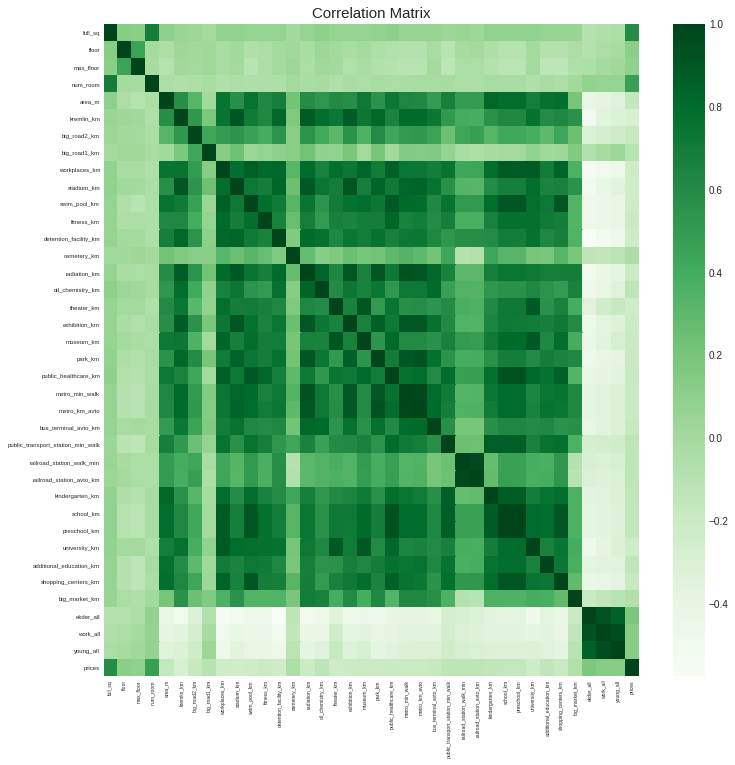

In [22]:
pl.figure(figsize=(12,12)); cols=df_train.corr().columns.values
sn.heatmap(df_train.corr(),cmap=pl.cm.Greens,
           xticklabels=cols,yticklabels=cols)
pl.title("Correlation Matrix",fontsize=15)
pl.xticks(fontsize=5); pl.yticks(fontsize=6); pl.show()

Scaling, shuffling, and splitting

In [23]:
target_train,features_train=\
df_train['prices'].values,df_train.drop('prices',1).values
features_train_cat,features_train_cat_enc=\
df_train_cat.drop('prices',1).values,\
df_train_cat1.drop('prices',1).values
features_test,features_test_cat,features_test_cat_enc=\
df_test.values,df_test_cat.values,df_test_cat1.values
sp.pprint('Numeric Features')
X_train,X_test,y_train,y_test=\
train_test_split(features_train,target_train,test_size=.2,random_state=1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

Numeric Features


((16719, 38), (4180, 38), (16719,), (4180,))

In [24]:
sp.pprint('Numeric and Categorical Features')
X_train_cat,X_test_cat,y_train_cat,y_test_cat=\
train_test_split(features_train_cat,target_train,test_size=.2,random_state=1)
X_train_cat.shape,X_test_cat.shape,y_train_cat.shape,y_test_cat.shape

Numeric and Categorical Features


((16719, 46), (4180, 46), (16719,), (4180,))

In [25]:
sp.pprint('Numeric and Encoded Categorical Features')
X_train_cat_enc,X_test_cat_enc,y_train_cat_enc,y_test_cat_enc=\
train_test_split(features_train_cat_enc,target_train,test_size=.2,random_state=1)
X_train_cat_enc.shape,X_test_cat_enc.shape,\
y_train_cat_enc.shape,y_test_cat_enc.shape

Numeric and Encoded Categorical Features


((16719, 638), (4180, 638), (16719,), (4180,))

In [26]:
#for [Xtrain,ytrain,Xtest,ytest] in \
#[[X_train,y_train,X_test,y_test],
# [X_train_cat,y_train_cat,X_test_cat,y_test_cat],
# [X_train_cat_enc,y_train_cat_enc,X_test_cat_enc,y_test_cat_enc]]:
#      Xtrain,ytrain,Xtest,ytest=robust_scaler(Xtrain,ytrain,Xtest,ytest)

<h1 class='font-effect-3d' style='color:#31c831; font-family:Orbitron;'> Benchmark Models</h1>
<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'>Regressors</h4>

GradientBoostingRegressor. Numeric Features
<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>
EV score. Train: 0.86392300538784
EV score. Test: 0.7354599120077993
-_--_--_--_--_--_--_--_--_--_-
R2 score. Train: 0.86392300538784
R2 score. Test: 0.7354147732199827
-_--_--_--_--_--_--_--_--_--_-
MSE score. Train: 3207170259272.855
MSE score. Test: 6861148524011.1455
-_--_--_--_--_--_--_--_--_--_-
MAE score. Train: 1119975.4077018318
MAE score. Test: 1412341.2251767921
-_--_--_--_--_--_--_--_--_--_-
MdAE score. Train: 626627.2225059979
MdAE score. Test: 721274.6281221225


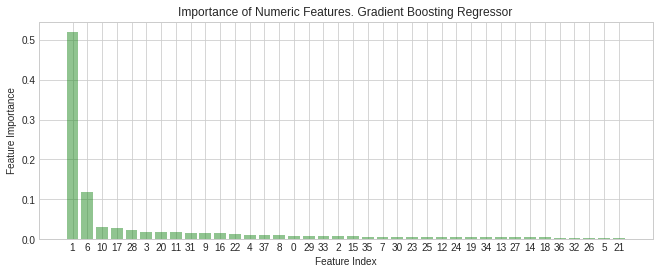

In [27]:
reg=GradientBoostingRegressor(max_depth=4,n_estimators=342)
y_train_gbr,y_test_gbr=\
regression(reg,X_train,X_test,y_train)
scores('GradientBoostingRegressor. Numeric Features',
       y_train,y_test,y_train_gbr,y_test_gbr)
ti="Importance of Numeric Features. Gradient Boosting Regressor"
display_importance(reg,X_train,y_train,ti,38)

GradientBoostingRegressor. Numeric and Categorical Features
<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>
EV score. Train: 0.8581868506184569
EV score. Test: 0.7237417208371104
-_--_--_--_--_--_--_--_--_--_-
R2 score. Train: 0.8581868506184569
R2 score. Test: 0.7236447448758543
-_--_--_--_--_--_--_--_--_--_-
MSE score. Train: 3342364492738.88
MSE score. Test: 7166365537007.976
-_--_--_--_--_--_--_--_--_--_-
MAE score. Train: 1139416.9881170364
MAE score. Test: 1409362.4485196334
-_--_--_--_--_--_--_--_--_--_-
MdAE score. Train: 638360.4218059555
MdAE score. Test: 728506.2709526629


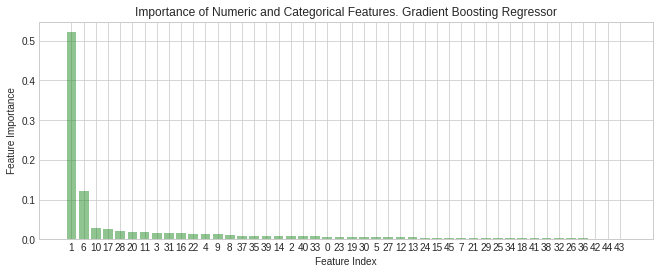

In [28]:
reg_cat=GradientBoostingRegressor(max_depth=4,n_estimators=308)
y_train_cat_gbr,y_test_cat_gbr=\
regression(reg_cat,X_train_cat,X_test_cat,y_train_cat)
ti='GradientBoostingRegressor. Numeric and Categorical Features'
scores(ti,y_train_cat,y_test_cat,y_train_cat_gbr,y_test_cat_gbr)
ti="Importance of Numeric and Categorical Features."+\
   " Gradient Boosting Regressor"
display_importance(reg_cat,X_train_cat,y_train_cat,ti,46)

In [29]:
reg_cat_enc=GradientBoostingRegressor(max_depth=3,n_estimators=159)
y_train_cat_enc_gbr,y_test_cat_enc_gbr=\
regression(reg_cat_enc,X_train_cat_enc,X_test_cat_enc,y_train_cat_enc)
scores('GradientBoostingRegressor. Numeric and Encoded Categorical Features',
       y_train_cat_enc,y_test_cat_enc,
       y_train_cat_enc_gbr,y_test_cat_enc_gbr)

GradientBoostingRegressor. Numeric and Encoded Categorical Features
<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>
EV score. Train: 0.7749929775666036
EV score. Test: 0.722239016542365
-_--_--_--_--_--_--_--_--_--_-
R2 score. Train: 0.7749929775666036
R2 score. Test: 0.7222026633131826
-_--_--_--_--_--_--_--_--_--_-
MSE score. Train: 5303143507340.828
MSE score. Test: 7203761184171.056
-_--_--_--_--_--_--_--_--_--_-
MAE score. Train: 1394277.6462952306
MAE score. Test: 1491913.3609781337
-_--_--_--_--_--_--_--_--_--_-
MdAE score. Train: 746254.7830811702
MdAE score. Test: 788619.2906513256


<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'>Regressors with Dimensionality Reduction</h4>

GradientBoostingRegressor. Numeric Features (PCA)
<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>
EV score. Train: 0.8278686800608844
EV score. Test: 0.6933025440514567
-_--_--_--_--_--_--_--_--_--_-
R2 score. Train: 0.8278686800608844
R2 score. Test: 0.6929613011879032
-_--_--_--_--_--_--_--_--_--_-
MSE score. Train: 4056927121087.224
MSE score. Test: 7962039834221.099
-_--_--_--_--_--_--_--_--_--_-
MAE score. Train: 1246086.2518887992
MAE score. Test: 1515566.4742021977
-_--_--_--_--_--_--_--_--_--_-
MdAE score. Train: 675073.0664029289
MdAE score. Test: 769644.9302950869


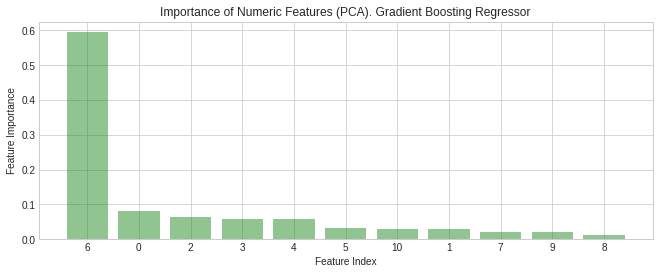

In [30]:
pca=PCA(n_components=11).fit(X_train)
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)
reg_pca=GradientBoostingRegressor(max_depth=4,n_estimators=38*8)
y_train_gbr_pca,y_test_gbr_pca=\
regression(reg_pca,X_train_pca,X_test_pca,y_train)
scores('GradientBoostingRegressor. Numeric Features (PCA)',
       y_train,y_test,y_train_gbr_pca,y_test_gbr_pca)
ti="Importance of Numeric Features (PCA). Gradient Boosting Regressor"
display_importance(reg_pca,X_train_pca,y_train,ti,11)

<h4 style='color:#31c831; font-family:Roboto; text-shadow:4px 4px 4px #aaa;'> Neural Networks</h4>

In [31]:
def mlp_model():
    model=Sequential()
    model.add(Dense(32*32,activation='relu',input_dim=38))
    model.add(Dense(32*4,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))    
    model.compile(loss='mse',optimizer='nadam',metrics=['mae'])
    return model
mlp_model=mlp_model()
checkpointer=ks.callbacks.ModelCheckpoint(filepath=fw,save_best_only=True)
lr_reduction=ks.callbacks.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                            patience=5,factor=.95)
history=mlp_model.fit(X_train,y_train,validation_data=(X_test,y_test),
                      nb_epoch=300,batch_size=12,verbose=2,
                      callbacks=[checkpointer,lr_reduction])

Train on 16719 samples, validate on 4180 samples
Epoch 1/300
 - 5s - loss: 41471751486312.0391 - mae: 4425673.0000 - val_loss: 35534769244291.3047 - val_mae: 3921280.0000
Epoch 2/300
 - 4s - loss: 34223923585325.3398 - mae: 3910273.7500 - val_loss: 36265041368807.7500 - val_mae: 3922401.5000
Epoch 3/300
 - 4s - loss: 33425418445236.5703 - mae: 3845484.2500 - val_loss: 35001724446137.9375 - val_mae: 3824150.5000
Epoch 4/300
 - 4s - loss: 33046436456474.0898 - mae: 3834030.7500 - val_loss: 36114908265978.6094 - val_mae: 3967713.2500
Epoch 5/300
 - 4s - loss: 33150585387777.1484 - mae: 3832039.2500 - val_loss: 35442582229035.1172 - val_mae: 3806460.5000
Epoch 6/300
 - 4s - loss: 32971323927203.8086 - mae: 3828750.5000 - val_loss: 34463393698352.5039 - val_mae: 3819476.5000
Epoch 7/300
 - 5s - loss: 32834254802705.1367 - mae: 3816126.5000 - val_loss: 36556824156381.4609 - val_mae: 3988613.0000
Epoch 8/300
 - 5s - loss: 32543187815559.4180 - mae: 3804800.0000 - val_loss: 41102344766960.8125

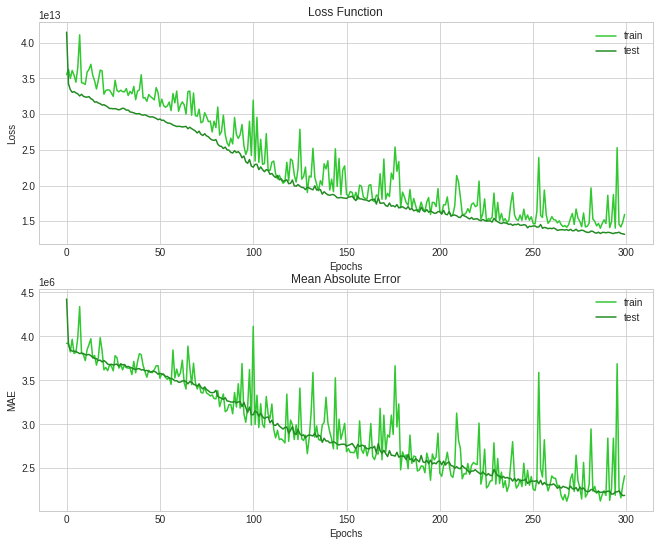

MLP Initial Model. Numeric Features
<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>
EV score. Train: 0.475821793197469
EV score. Test: 0.4624306295196502
-_--_--_--_--_--_--_--_--_--_-
R2 score. Train: 0.4706338494886272
R2 score. Test: 0.45917052880281595
-_--_--_--_--_--_--_--_--_--_-
MSE score. Train: 12476520215814.04
MSE score. Test: 14024635363075.146
-_--_--_--_--_--_--_--_--_--_-
MAE score. Train: 2069135.3496844906
MAE score. Test: 2128284.129007177
-_--_--_--_--_--_--_--_--_--_-
MdAE score. Train: 1182981.5
MdAE score. Test: 1217398.0


In [32]:
history_plot(history)
mlp_model.load_weights(fw)
y_train_mlp=mlp_model.predict(X_train)
y_test_mlp=mlp_model.predict(X_test)
scores('MLP Initial Model. Numeric Features',
       y_train,y_test,y_train_mlp,y_test_mlp)

In [33]:
def mlp_cat_model():
    model = Sequential()    
    model.add(Dense(32*32,activation='relu',input_dim=46))
    model.add(Dense(32*4,activation='relu'))   
    model.add(Dense(1,kernel_initializer='normal'))    
    model.compile(loss='mse',optimizer='nadam',metrics=['mae'])
    return model
mlp_cat_model=mlp_cat_model()
checkpointer=ks.callbacks\
.ModelCheckpoint(filepath=fw,save_best_only=True)
lr_reduction=ks.callbacks\
.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                   patience=5,factor=.95)
history=mlp_cat_model.fit(X_train_cat,y_train_cat,
                          validation_data=(X_test_cat,y_test_cat),
                          nb_epoch=300,batch_size=12,verbose=2,
                          callbacks=[checkpointer,lr_reduction])

Train on 16719 samples, validate on 4180 samples
Epoch 1/300
 - 8s - loss: 42194495861257.0938 - mae: 4471899.5000 - val_loss: 36526405729473.0391 - val_mae: 3970002.0000
Epoch 2/300
 - 6s - loss: 33418560455787.8555 - mae: 3848597.2500 - val_loss: 35197435805790.0703 - val_mae: 3770573.5000
Epoch 3/300
 - 5s - loss: 33291078623750.8906 - mae: 3839123.0000 - val_loss: 34758383896534.8438 - val_mae: 3806122.2500
Epoch 4/300
 - 5s - loss: 33104365788512.2383 - mae: 3840760.0000 - val_loss: 34827536999082.0117 - val_mae: 3803482.7500
Epoch 5/300
 - 4s - loss: 32749548373420.3047 - mae: 3814005.0000 - val_loss: 34889370179962.2383 - val_mae: 3815211.7500
Epoch 6/300
 - 4s - loss: 32656720058365.4297 - mae: 3810478.5000 - val_loss: 34880745974494.9258 - val_mae: 3822422.2500
Epoch 7/300
 - 4s - loss: 32528191163453.9219 - mae: 3800910.5000 - val_loss: 34128391592486.7070 - val_mae: 3738575.0000
Epoch 8/300
 - 4s - loss: 32453915327838.7656 - mae: 3785166.0000 - val_loss: 34106059627658.1680

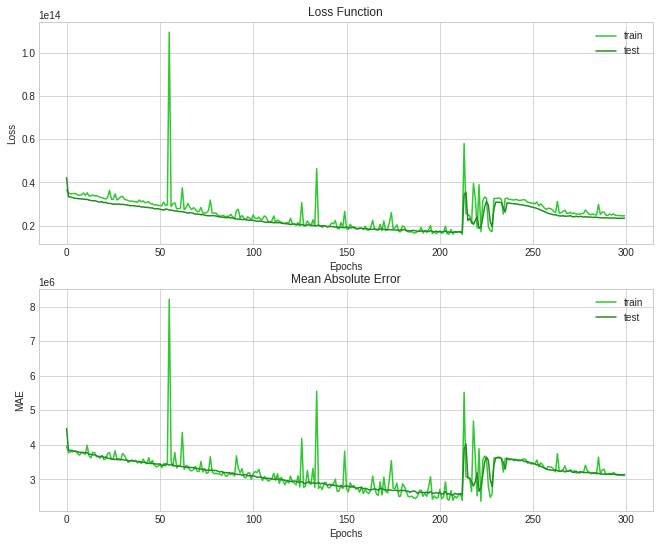

MLP Initial Model. Numeric and Categorical Features
<_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_><_>
EV score. Train: 0.33323487918382155
EV score. Test: 0.38480809989403186
-_--_--_--_--_--_--_--_--_--_-
R2 score. Train: 0.33025286837659185
R2 score. Test: 0.38327171952645356
-_--_--_--_--_--_--_--_--_--_-
MSE score. Train: 15785130233791.549
MSE score. Test: 15992821605286.182
-_--_--_--_--_--_--_--_--_--_-
MAE score. Train: 2377958.1653657514
MAE score. Test: 2391379.974401914
-_--_--_--_--_--_--_--_--_--_-
MdAE score. Train: 1424354.0
MdAE score. Test: 1433643.75


In [34]:
history_plot(history)
mlp_cat_model.load_weights(fw)
y_train_cat_mlp=mlp_cat_model.predict(X_train_cat)
y_test_cat_mlp=mlp_cat_model.predict(X_test_cat)
scores('MLP Initial Model. Numeric and Categorical Features',
       y_train_cat,y_test_cat,y_train_cat_mlp,y_test_cat_mlp)

<h1 class='font-effect-3d' style='color:#31c831; font-family:Orbitron;'> Predictions</h1>

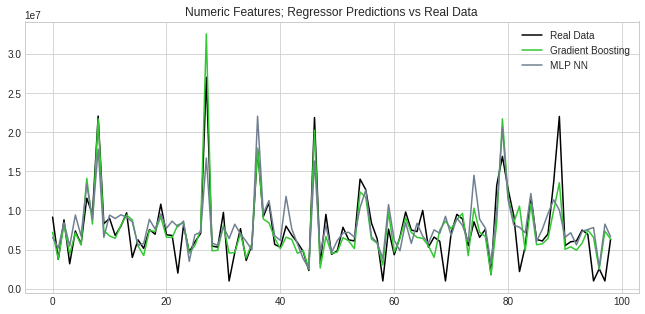

In [35]:
n=100; pl.figure(figsize=(11,5))
pl.plot(y_test[1:n],color='black',label='Real Data')
pl.plot(y_test_gbr[1:n],label='Gradient Boosting',color='#31c831')
pl.plot(y_test_mlp[1:n],label='MLP NN',color='slategray')
pl.title("Numeric Features; Regressor Predictions vs Real Data")
pl.legend(); pl.show()

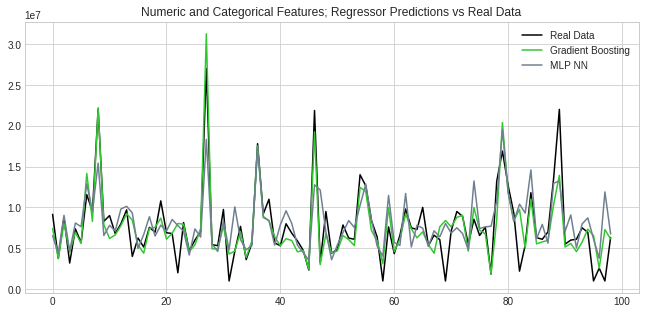

In [36]:
n=100; pl.figure(figsize=(11,5))
pl.plot(y_test_cat[1:n],color='black',label='Real Data')
pl.plot(y_test_cat_gbr[1:n],label='Gradient Boosting',color='#31c831')
pl.plot(y_test_cat_mlp[1:n],label='MLP NN',color='slategray')
pl.title("Numeric and Categorical Features; "+\
         "Regressor Predictions vs Real Data")
pl.legend(); pl.show()

<h1 class='font-effect-3d' style='color:#31c831; font-family:Orbitron;'> Submissions</h1>

In [37]:
scale=RobustScaler()
features_train=scale.fit_transform(features_train)
features_test=scale.transform(features_test)

In [38]:
reg=GradientBoostingRegressor(n_estimators=141,max_depth=4)
reg.fit(features_train,target_train)
target_train_predict=reg.predict(features_train)
target_test_predict=reg.predict(features_test)

In [39]:
print("_______________________________________")
print("Gradient Boosting  Regressor")
print("_______________________________________")
print("EV score. Train: ",
      explained_variance_score(target_train,target_train_predict))
print("---------")
print("R2 score. Train: ",
      r2_score(target_train,target_train_predict))
print("---------")
print("MSE score. Train: ",
      mean_squared_error(target_train,target_train_predict))
print("---------")
print("MAE score. Train: ", 
      mean_absolute_error(target_train,target_train_predict))
print("---------")
print("MdAE score. Train: ",
      median_absolute_error(target_train,target_train_predict))

_______________________________________
Gradient Boosting  Regressor
_______________________________________
EV score. Train:  0.8113426082208652
---------
R2 score. Train:  0.8113426082208652
---------
MSE score. Train:  4535680992454.605
---------
MAE score. Train:  1293594.2954819177
---------
MdAE score. Train:  694628.8597180434


In [40]:
pd.set_option('display.float_format',lambda x:'%.2f'%x)
target_predict=["{0:.2f}".format(x) for x in target_test_predict]
submission=pd.DataFrame({"id": test['id'],
                         "price_doc":target_predict})
print(submission[0:5])
# submission.to_csv('kaggle_sberbank_housing.csv',index=False)

      id   price_doc
0  30474  5637329.04
1  30475  7980764.74
2  30476  5574035.79
3  30477  5939779.05
4  30478  5319024.37
